# ONNX visualization

[ONNX](https://onnx.ai/) is a serialization format for machine learned model. It is a list of mathematical functions used to describe every prediction function for standard and deep machine learning. Module [onnx](https://github.com/onnx/onnx) offers some tools to [display ONNX graph](http://www.xavierdupre.fr/app/sklearn-onnx/helpsphinx/auto_examples/plot_pipeline.html). [Netron](https://github.com/lutzroeder/netron) is another approach. The following notebooks explore a ligher visualization.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Train a model

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = LogisticRegression(solver='liblinear')
clr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Convert a model

In [3]:
import numpy
from mlprodict.onnxrt import to_onnx
model_onnx = to_onnx(clr, X_train.astype(numpy.float32))

The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.


## Explore it with OnnxInference

In [4]:
from mlprodict.onnxrt import OnnxInference

sess = OnnxInference(model_onnx)
sess

OnnxInference(...)

In [5]:
print(sess)

ir_version: 5
producer_name: "skl2onnx"
producer_version: "1.5.9999"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "X"
    output: "label"
    output: "probability_tensor"
    name: "LinearClassifier"
    op_type: "LinearClassifier"
    attribute {
      name: "classlabels_ints"
      ints: 0
      ints: 1
      ints: 2
      type: INTS
    }
    attribute {
      name: "coefficients"
      floats: 0.38034090399742126
      floats: 1.3887642621994019
      floats: -2.118476390838623
      floats: -0.990760326385498
      floats: 0.5423761606216431
      floats: -1.6354268789291382
      floats: 0.4472496509552002
      floats: -1.141257882118225
      floats: -1.6641192436218262
      floats: -1.1513200998306274
      floats: 2.2040655612945557
      floats: 2.264425039291382
      type: FLOATS
    }
    attribute {
      name: "intercepts"
      floats: 0.2671399712562561
      floats: 0.7125123143196106
      floats: -0.8974258303642273
      type: FLO

## dot

In [6]:
dot = sess.to_dot()
print(dot)

digraph{
  ranksep=0.25;
  nodesep=0.05;
  orientation=portrait;

  X [shape=box color=red label="X\nfloat((0, 4))" fontsize=10];

  output_label [shape=box color=green label="output_label\nint64((1,))" fontsize=10];
  output_probability [shape=box color=green label="output_probability\n[{int64, {'kind': 'tensor', 'elem': 'float', 'shape': }}]" fontsize=10];


  label [shape=box label="label" fontsize=10];
  probability_tensor [shape=box label="probability_tensor" fontsize=10];
  LinearClassifier [shape=box style="filled,rounded" color=orange label="LinearClassifier\n(LinearClassifier)\nclasslabels_ints=[0 1 2]\ncoefficients=[ 0.3803409   1.38...\nintercepts=[ 0.26713997  0.7125...\nmulti_class=1\npost_transform=b'LOGISTIC'" fontsize=10];
  X -> LinearClassifier;
  LinearClassifier -> label;
  LinearClassifier -> probability_tensor;

  probabilities [shape=box label="probabilities" fontsize=10];
  Normalizer [shape=box style="filled,rounded" color=orange label="Normalizer\n(Normalizer)

In [7]:
from jyquickhelper import RenderJsDot
RenderJsDot(dot)  # add local=True if nothing shows up

## magic commands

The module implements a magic command to easily display graphs.

In [8]:
%load_ext mlprodict

In [9]:
# add -l 1 if nothing shows up
%onnxview model_onnx

## Shape information

It is possible to use the python runtime to get an estimation of each node shape.

In [10]:
%onnxview model_onnx -a 1

The shape ``(n, 2)`` means a matrix with an indefinite number of rows and 2 columns.

## runtime

Let's compute the prediction using a Python runtime.

In [11]:
prob = sess.run({'X': X_test})['output_probability']
prob[:5]

{0: array([0.05718492, 0.00298655, 0.00102123, 0.86115095, 0.01935183]),
 1: array([0.684343  , 0.43610058, 0.38403133, 0.13862167, 0.61728042]),
 2: array([2.58472078e-01, 5.60912867e-01, 6.14947440e-01, 2.27374079e-04,
        3.63367750e-01])}

In [12]:
import pandas
prob = pandas.DataFrame(list(prob)).values
prob[:5]

array([[5.71849246e-02, 6.84342997e-01, 2.58472078e-01],
       [2.98654917e-03, 4.36100584e-01, 5.60912867e-01],
       [1.02122564e-03, 3.84031334e-01, 6.14947440e-01],
       [8.61150954e-01, 1.38621672e-01, 2.27374079e-04],
       [1.93518252e-02, 6.17280425e-01, 3.63367750e-01]])

Which we compare to the original model.

In [13]:
clr.predict_proba(X_test)[:5]

array([[5.71849458e-02, 6.84342959e-01, 2.58472095e-01],
       [2.98655048e-03, 4.36100570e-01, 5.60912879e-01],
       [1.02122624e-03, 3.84031316e-01, 6.14947458e-01],
       [8.61150957e-01, 1.38621669e-01, 2.27374094e-04],
       [1.93518332e-02, 6.17280394e-01, 3.63367773e-01]])

Some time measurement...

In [14]:
%timeit clr.predict_proba(X_test)

130 µs ± 5.69 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
%timeit sess.run({'X': X_test})['output_probability']

85.4 µs ± 4.69 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


With one observation:

In [16]:
%timeit clr.predict_proba(X_test[:1])

116 µs ± 4.06 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%timeit sess.run({'X': X_test[:1]})['output_probability']

75.9 µs ± 1.77 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%matplotlib inline

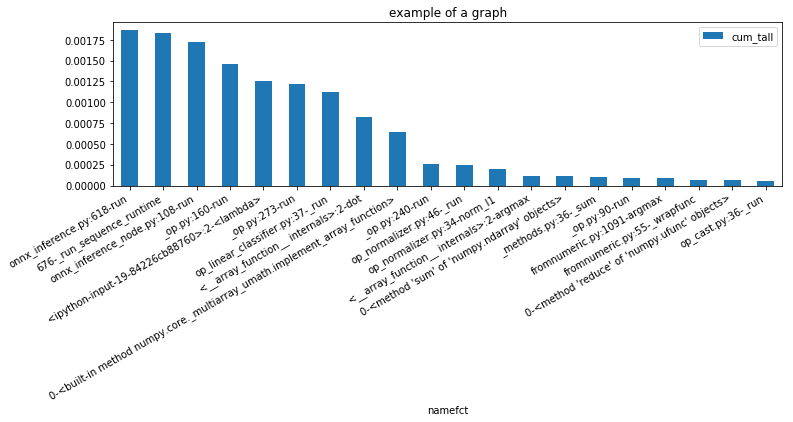

In [19]:
from pyquickhelper.pycode.profiling import profile
pr, df = profile(lambda: sess.run({'X': X_test})['output_probability'], as_df=True)
ax = df[['namefct', 'cum_tall']].head(n=20).set_index('namefct').plot(kind='bar', figsize=(12, 3), rot=30)
ax.set_title("example of a graph")
for la in ax.get_xticklabels():
    la.set_horizontalalignment('right');

## Add metadata

It is possible to add metadata once the model is converted.

In [20]:
meta = model_onnx.metadata_props.add()
meta.key = "key_meta"
meta.value = "value_meta"

In [21]:
list(model_onnx.metadata_props)

[key: "key_meta"
 value: "value_meta"]

In [22]:
model_onnx.metadata_props[0]

key: "key_meta"
value: "value_meta"